In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from datetime import datetime

In [2]:
df1 = pd.read_csv('357164042518400_OLs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                    "Longitude", "Speed", "Date", "Time", "Channel1", "Channel2"])
df1

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,20210304,41113,11200,4736
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,20210304,41113,-11265,511
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,20210304,41114,12464,2303
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,20210304,41114,-11265,511
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,20210304,41114,11644,1464
...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,20211108,23941,-2305,-11247
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,20211108,23941,-656,11472
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,20211108,23941,-560,-11272
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,20211108,23943,-832,11136


The acquired value is an integer number `[digit]` between 32768 and -32768. It can be converted
into a stress load using the sensitivity of 0.0068 `[MPa/digit]`. The absolute value is much more
important than the integer.

In [3]:
df1[['Channel1', 'Channel2']] = df1[['Channel1', 'Channel2']].apply(lambda x: abs(x * 0.0068), axis=1)
df1

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,20210304,41113,76.1600,32.2048
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,20210304,41113,76.6020,3.4748
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,20210304,41114,84.7552,15.6604
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,20210304,41114,76.6020,3.4748
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,20210304,41114,79.1792,9.9552
...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,20211108,23941,15.6740,76.4796
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,20211108,23941,4.4608,78.0096
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,20211108,23941,3.8080,76.6496
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,20211108,23943,5.6576,75.7248


In [4]:
df1['Time'] = df1['Time'].apply(lambda x: str(datetime.strptime(str(x), "%H%M%S").time()))
df1['Date'] = df1['Date'].apply(lambda x: str(datetime.strptime(str(x), "%Y%m%d").date()))
df1

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552
...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248


In [5]:
df1['max_overload'] = np.max(df1[['Channel1', 'Channel2']].values, axis=1)

In [6]:
overloads = np.max(df1[['Channel1', 'Channel2']].values, axis=1)
overloads[overloads > 85].shape

(3772,)

## Calculate distances

In [7]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
lat1 = 53.32055555555556
lat2 = 53.31861111111111
lon1 = -1.7297222222222221
lon2 =  -1.6997222222222223
print(distance(lat1, lat2, lon1, lon2), "K.M")

2.0043678382716137 K.M


In [8]:
a = np.sqrt(np.sum((np.array([lat1, lon1]) - np.array([lat2, lon2]))**2))
b = distance(lat1, lat2, lon1, lon2) * 1000

five_meter_degree = (5 * a) / b
print(five_meter_degree)

7.49935909658473e-05


In [9]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift(bandwidth=five_meter_degree)

We cluster the coordinates in each day

In [10]:
# first calculate for one day
coordinates = df1[['Latitude', 'Longitude']].values

In [11]:
mean_shift.fit(coordinates)
mean_shift.labels_

array([ 76,  76,  76, ..., 275, 714, 833])

In [12]:
np.unique(mean_shift.labels_)

array([   0,    1,    2, ..., 1077, 1078, 1079])

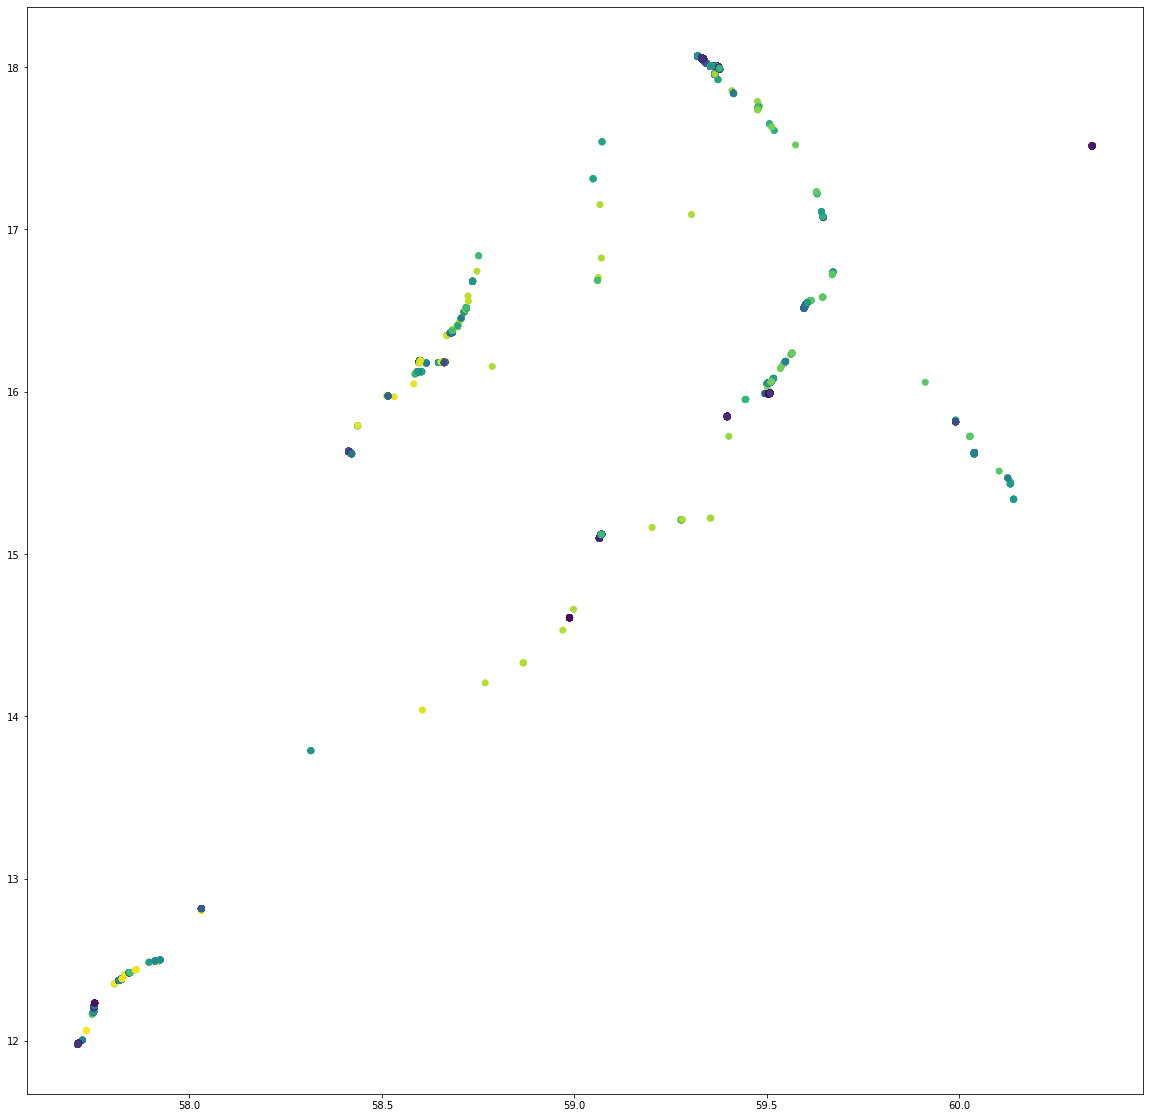

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
# coordinates = df1[['Latitude', 'Longitude']].values
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=mean_shift.labels_)
plt.show()

In [14]:
df1['5m_cluster'] = mean_shift.labels_
df1.head(30)

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048,76.1600,76
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748,76.6020,76
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604,84.7552,76
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748,76.6020,76
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552,79.1792,76
5,60040,CANALE1,357164042518400,59.374608,17.997948,0.0,2021-03-04,04:11:14,82.8444,0.8772,82.8444,64
6,60040,CANALE1,357164042518400,59.374606,17.997996,0.0,2021-03-04,04:11:15,87.4752,0.6528,87.4752,64
7,60040,CANALE1,357164042518400,59.374606,17.998020,0.0,2021-03-04,04:11:15,88.2368,12.0768,88.2368,64
8,60040,CANALE1,357164042518400,59.374605,17.998046,0.0,2021-03-04,04:11:15,75.5072,7.1808,75.5072,64
9,60040,CANALE1,357164042518400,59.374605,17.998049,0.0,2021-03-04,04:11:15,76.1056,15.2320,76.1056,64


In [15]:
df1_clone = df1.copy()
df1_clone_grouped = df1_clone.groupby('5m_cluster').first()
df1_clone_grouped = df1_clone_grouped.sort_values(by='Date')
df1_clone_grouped


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload
5m_cluster,,,,,,,,,,,
134,60040,CANALE1,357164042518400,59.374251,18.000485,0.0,2021-03-04,04:11:38,77.5744,10.8800,77.5744
172,60040,CANALE1,357164042518400,59.332705,18.053419,0.0,2021-03-04,04:21:30,77.4384,19.7472,77.4384
711,60040,CANALE1,357164042518400,59.443825,15.951563,0.0,2021-03-04,06:04:18,77.9008,28.9408,77.9008
23,60040,CANALE1,357164042518400,59.372817,18.003416,0.0,2021-03-04,04:12:14,87.8016,7.9424,87.8016
49,60040,CANALE1,357164042518400,59.373593,18.002372,0.0,2021-03-04,04:11:58,83.3408,4.3520,83.3408
...,...,...,...,...,...,...,...,...,...,...,...
275,60040,CANALE1,357164042518400,59.376689,17.991436,0.0,2021-11-08,23:09:41,76.5952,4.7872,76.5952
714,61040,CANALE1,357164042518400,59.376636,17.991631,0.0,2021-11-08,23:09:43,75.2012,4.6852,75.2012
222,60040,CANALE1,357164042518400,59.376777,17.990740,0.0,2021-11-08,23:09:33,79.1044,16.7280,79.1044


•
It’s interesting to monitor the variation of the overloads during time; whether the values
increase, decrease or remain constant

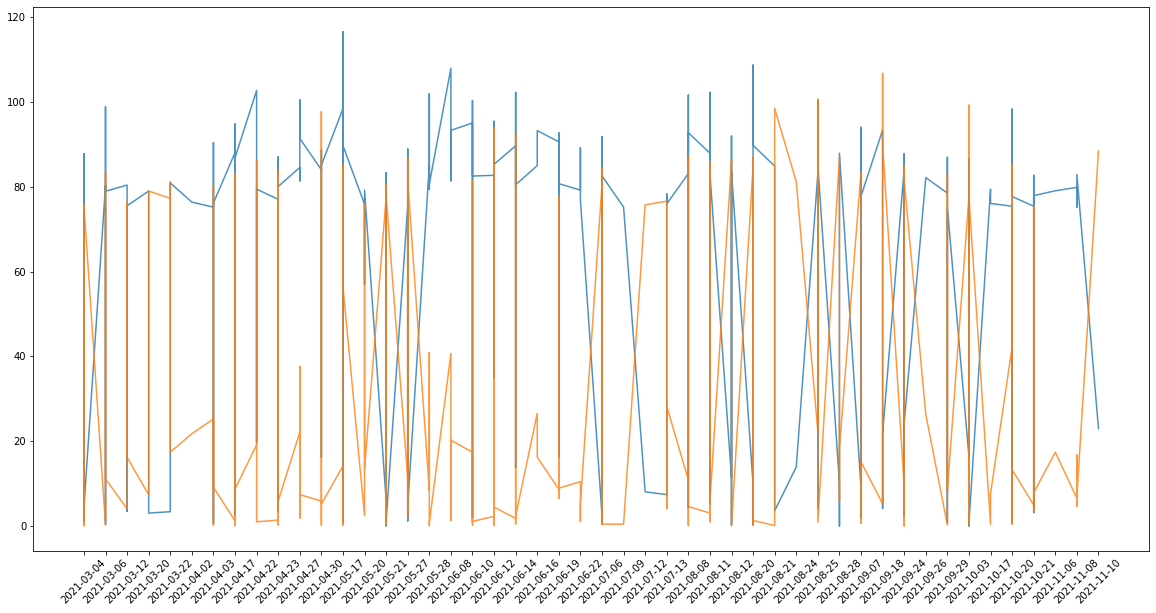

In [16]:
# plot the overloads during date

plt.figure(figsize=(20, 10))

plt.plot(df1_clone_grouped['Date'].values, df1_clone_grouped[['Channel1', 'Channel2']].values,alpha=0.8)
plt.xticks(rotation=45)
plt.show()

In [17]:
    
df2 = pd.read_csv('357164042518400_THs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time"], skiprows=lambda x: x % 2 != 0)
df2['Time'] = df2['Time'].apply(lambda x: str(datetime.strptime(str(x), "%H%M%S").time()))
df2['Date'] = df2['Date'].apply(lambda x: str(datetime.strptime(str(x), "%Y%m%d").date()))
df2

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time
0,60040,CANALE1,357164042518400,59.372755,18.003537,0.0,2021-03-04,04:12:15
1,60040,CANALE1,357164042518400,59.373505,18.002518,0.0,2021-03-04,04:12:00
2,60040,CANALE1,357164042518400,59.373719,18.002101,0.0,2021-03-04,04:11:54
3,60040,CANALE1,357164042518400,59.374128,18.001012,0.0,2021-03-04,04:11:43
4,60040,CANALE1,357164042518400,59.372899,18.003275,0.0,2021-03-04,04:12:12
...,...,...,...,...,...,...,...,...
388,60040,CANALE2,357164042518400,59.505874,15.988249,0.0,2021-10-20,15:51:10
389,60040,CANALE2,357164042518400,59.507716,15.990146,0.0,2021-10-20,15:51:20
390,60040,CANALE2,357164042518400,59.506697,15.988626,0.0,2021-10-20,15:51:14
391,60040,CANALE2,357164042518400,59.334602,18.050718,0.0,2021-10-21,05:19:07


In [18]:
df3 = pd.read_csv('357164042518400_THs.csv', delimiter=';',
                  skiprows=lambda x: x % 2 == 0, names=list(range(5001)))
df4 = df3.abs().max(axis=1)
df2['time_series_overload'] = df4


In [19]:
df2[['time_series_overload']] = df2[['time_series_overload']].apply(
    lambda x: abs(x * 0.0068), axis=1)



In [20]:
date_time_1 = df1[['Date', 'Time']].values.tolist()
date_time_2 = df2[['Date','Time']].values.tolist()

dt_1 = list(map(' '.join, date_time_1))
dt_2 = list(map(' '.join, date_time_2))
counter = 0
for date, overload1, coor1 in zip(dt_1, np.max(df1[['Channel1', 'Channel2']].values, axis=1).tolist(), df1[['Latitude', 'Longitude']].values.tolist()):
    for d, overload2, coor2 in zip(dt_2, df2['time_series_overload'].values.tolist(), df2[['Latitude', 'Longitude']].values.tolist()):
        if date == d and overload1==overload2 and coor1 == coor2:
            counter += 1
print(counter)

counter = 0
for date, overload1 in zip(dt_1, df1[['Latitude', 'Longitude']].values.tolist()):
    for d, overload2 in zip(dt_2, df2[['Latitude', 'Longitude']].values.tolist()):
        if date == d and overload1==overload2:
            counter += 1
print(counter)

390
481


In [21]:
mean_shift_2 = MeanShift(bandwidth=five_meter_degree)

mean_shift_2.fit(df2[['Latitude', 'Longitude']].values)
df2_clusters = mean_shift_2.labels_
print(df2_clusters)

[  7  42  39   2   6  50  54  59  95  97 256  96  98 254 252 251 152  45
 177 161 155 184  49 109 108 162   5  41  38   7   6  53  51  60 209   8
  62  47  44  40   2 181  65  72  68  27 121 120  21 103 105 102 106  20
  24  22  23  88  83 111 257 100 260 101  99 140 219 139 142 143 146  79
 195  58 187  48 157  12  35 159 160 166 145 135 193 194 217  74 210 179
 175   4   3 171 168 188  14  76 200 110 262  34 150 165  13   4   5  37
  15  71 249  82 230  81 228  11   0 127 131  10 118  64  19  70 214   9
   9  84  86  87  17  17  18  90 235 234  75 231  85 236  94  92  93 201
 205 223  89 240 239  91 246 183  55 149   1   1 123 122 191   8  77 212
  73  36 172  52  46  43   3  16  69  63  61  31 125  29  30  10  26 119
  56  57  66 197  80  25 224 226  12 222 144 137  33  78 147  11 130 113
  67 208 151 153   6  42  39   2   7  50  54  59 216  95 247 133  96  97
  98 255 253 250  45 174 173 164 163 185  49 115   6  38  41 170   5   7
  53  51  60  16   8  62  47 182  44  40   2  15  7

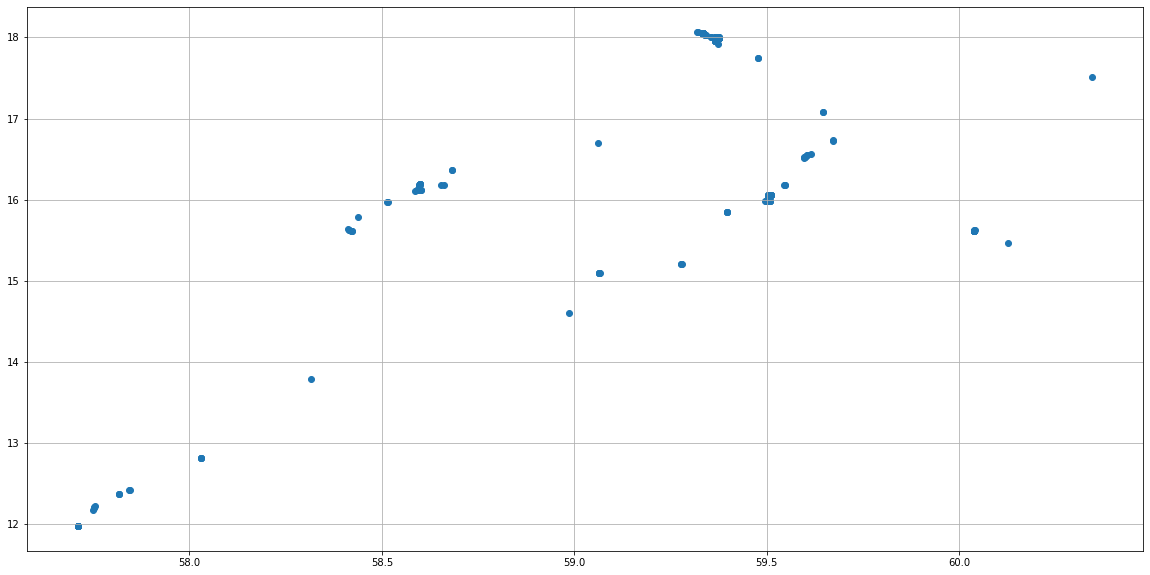

In [22]:
df2_centers = mean_shift_2.cluster_centers_
plt.figure(figsize=(20, 10))
plt.scatter(df2_centers[:, 0], df2_centers[:, 1])
plt.grid()
plt.show()

To show just the points that are important (e.g. important nod in each five meters)

In [23]:
important_nodes = []
for cluster in np.unique(df1['5m_cluster'].values):
    important_nodes.append(df1.loc[df1['5m_cluster']==cluster].sort_values('max_overload', ascending=False).iloc[0].values.tolist())
  


In [24]:
important_nodes_df = pd.DataFrame(important_nodes, columns=df1.columns)
imp_coord = important_nodes_df[['Latitude', 'Longitude']].values
important_nodes_df

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster
0,60040,CANALE2,357164042518400,59.507846,15.990516,0.000000,2021-07-06,09:26:46,5.6576,84.8640,84.8640,0
1,61040,CANALE1,357164042518400,59.504811,15.988259,0.000000,2021-08-20,05:46:53,93.0784,0.0000,93.0784,1
2,61040,CANALE1,357164042518400,59.597706,16.521523,0.069127,2021-09-07,08:58:10,85.7344,10.4176,85.7344,2
3,60040,CANALE2,357164042518400,59.507988,15.990847,0.000000,2021-08-25,05:29:43,5.1136,86.2784,86.2784,3
4,60040,CANALE2,357164042518400,59.505526,15.988311,0.000000,2021-07-06,09:26:33,4.6784,91.8816,91.8816,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,60040,CANALE1,357164042518400,57.748472,12.167601,0.000000,2021-03-06,05:07:57,82.2528,5.4400,82.2528,1075
1076,60040,CANALE1,357164042518400,57.747806,12.165386,26.529122,2021-04-03,06:08:27,76.5884,4.8960,76.5884,1076
1077,60040,CANALE1,357164042518400,57.732783,12.064450,0.000000,2021-06-12,04:04:47,82.6880,2.2848,82.6880,1077
1078,61040,CANALE1,357164042518400,57.732748,12.063970,0.000000,2021-09-26,04:55:14,82.1440,26.3296,82.1440,1078


In [25]:
df1

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048,76.1600,76
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748,76.6020,76
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604,84.7552,76
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748,76.6020,76
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552,79.1792,76
...,...,...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796,76.4796,275
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096,78.0096,275
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496,76.6496,275
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248,75.7248,714


<AxesSubplot:>

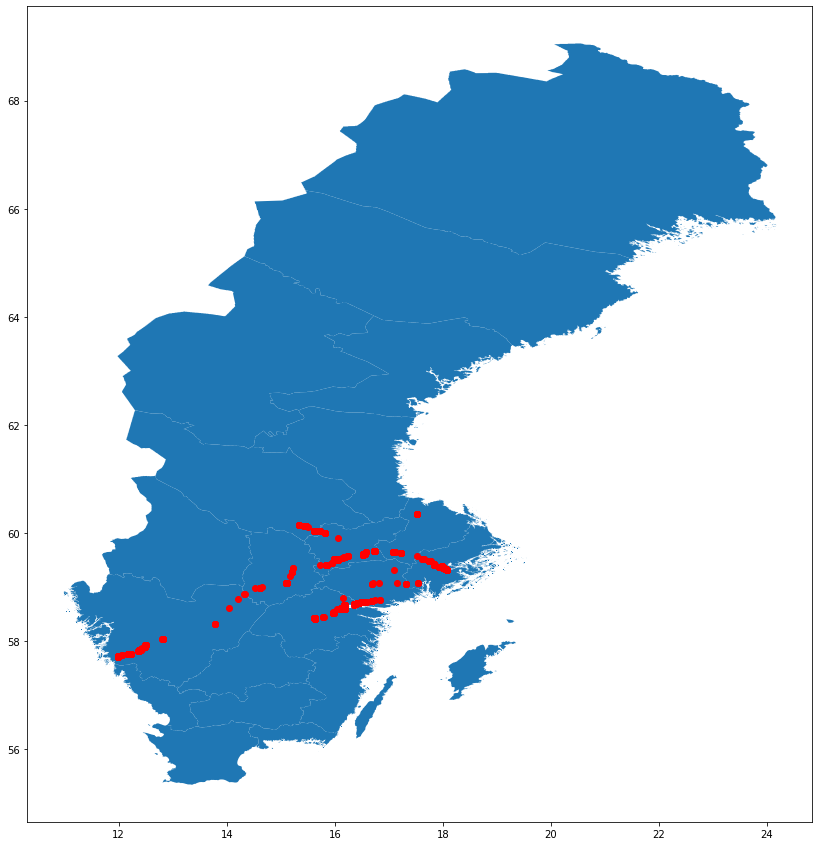

In [36]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.Longitude, df1.Latitude))


sweden_map = gpd.read_file('gis_map/test.shp')
ax = sweden_map.plot(figsize=(15, 15))
gdf.plot(ax=ax, color='red')

### device_id is const and is not useful for our work, so we drop taht

In [27]:
del df1['Device_id'], df2['Device_id']


In [28]:
df3 = df1.groupby('5m_cluster')
df3 = df3.first()
# del df3['5m_cluster']
df3


,Sensor_id,Channel,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,geometry
5m_cluster,,,,,,,,,,,
0,60040,CANALE1,59.507842,15.990506,0.000000,2021-07-06,09:26:46,81.8176,6.0928,81.8176,POINT (15.99051 59.50784)
1,60040,CANALE1,59.504791,15.988261,0.000000,2021-08-20,05:46:52,83.5584,16.1024,83.5584,POINT (15.98826 59.50479)
2,61040,CANALE1,59.597591,16.521567,0.000000,2021-07-13,06:45:52,75.9424,28.2336,75.9424,POINT (16.52157 59.59759)
3,60040,CANALE1,59.507938,15.990778,0.000000,2021-07-06,09:26:47,83.5312,4.3520,83.5312,POINT (15.99078 59.50794)
4,60040,CANALE2,59.505555,15.988156,0.000000,2021-03-06,08:25:56,12.7296,80.9472,80.9472,POINT (15.98816 59.50556)
...,...,...,...,...,...,...,...,...,...,...,...
1075,60040,CANALE1,57.748472,12.167601,0.000000,2021-03-06,05:07:57,82.2528,5.4400,82.2528,POINT (12.16760 57.74847)
1076,60040,CANALE1,57.747806,12.165386,26.529122,2021-04-03,06:08:27,76.5884,4.8960,76.5884,POINT (12.16539 57.74781)
1077,60040,CANALE1,57.732783,12.064450,0.000000,2021-06-12,04:04:47,82.6880,2.2848,82.6880,POINT (12.06445 57.73278)


In [29]:
import geopandas as gpd

In [30]:
# create new datafram to add x,y shpe var
gdf = gpd.GeoDataFrame(df1,)